<h1 style="text-align:center;">Practical session 3</h1>
<h2 style="text-align:center;">Biomedical Data Science</h2>
<h3 style="text-align:center;">Lucas Fayolle & Jose Valero</h3>

# Block 0. Libraries

In [1]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
import itertools
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from sklearn.preprocessing import label_binarize

# Block I. Data preparation

## 1. Load your data and extract basic data descriptors using the pandas profiling package

### 1.1 Load Data

In [3]:
df = pd.read_csv("Metabolite_concentrations_diagnosis.csv", sep = ";", usecols=range(1,17))

metabolite_columns = df.columns[df.columns != 'TYPE']
df[metabolite_columns] = df[metabolite_columns].apply(lambda x: x.str.replace(',', '.').astype(float))

df

,METABOLITE 0,METABOLITE 1,METABOLITE 2,METABOLITE 3,METABOLITE 4,METABOLITE 5,METABOLITE 6,METABOLITE 7,METABOLITE 8,METABOLITE 9,METABOLITE 10,METABOLITE 11,METABOLITE 12,METABOLITE 13,METABOLITE 14,TYPE
0,0.322695,0.575024,0.742645,0.635958,0.544804,0.785336,0.885756,0.577938,0.123017,0.701689,0.731254,0.846980,3.551957,3.742832,1.719949,MENINGIOMA
1,0.457408,0.764700,0.444451,0.451300,0.388213,0.401597,0.382574,0.407632,0.715072,1.216084,1.204490,2.329079,3.179366,3.117351,1.252479,MENINGIOMA
2,1.452870,1.152910,0.647735,0.622494,0.648020,0.826787,0.797439,0.695269,0.850328,0.910488,0.914841,1.805095,2.156737,2.152553,1.081571,MENINGIOMA
3,0.157588,0.314415,0.251613,0.186498,0.100556,0.287618,0.334349,0.213802,0.305852,0.754096,0.627211,1.566407,4.274654,4.210731,1.128131,MENINGIOMA
4,0.368681,0.206993,0.211521,0.034699,0.164187,0.364590,0.340892,0.110287,0.260206,0.531801,0.496068,0.654805,4.070067,4.324002,1.350580,MENINGIOMA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,1.146621,1.952639,1.240700,1.216044,0.873140,1.341280,1.344396,0.566293,0.714166,2.140718,2.027257,0.735564,0.975908,1.080736,0.984968,GLIOBLASTOMA
87,1.304585,1.048878,1.456252,1.391773,0.716365,1.224394,1.465654,1.349410,0.868388,2.699551,2.731945,0.795505,0.725981,0.700257,0.622597,GLIOBLASTOMA
88,1.648198,1.965646,0.913688,0.925384,1.040036,1.344963,1.313133,0.635587,0.974705,1.477950,1.421918,0.643054,1.233130,1.254060,1.052289,GLIOBLASTOMA
89,0.524946,0.711819,0.459294,0.450123,0.532891,0.464126,0.539442,0.431146,0.263541,1.087815,1.003663,0.888594,2.263318,2.392848,2.219673,GLIOBLASTOMA


### 1.2 Exploratory analysis

In [4]:
# profile = ProfileReport(df, title='Metabolite Concentrations Diagnosis Report')
# profile.to_file('metabolite_profile_report.html')

Some important things for later sections that are worth extracting from the report:

- En los metabolitos hay algunos valores extremos que hay que eliminar
- No hay valores faltantes, por lo tanto ningun metodo de imputación debe ser utilziado
- La correlación entre las variables es la siguiente: 

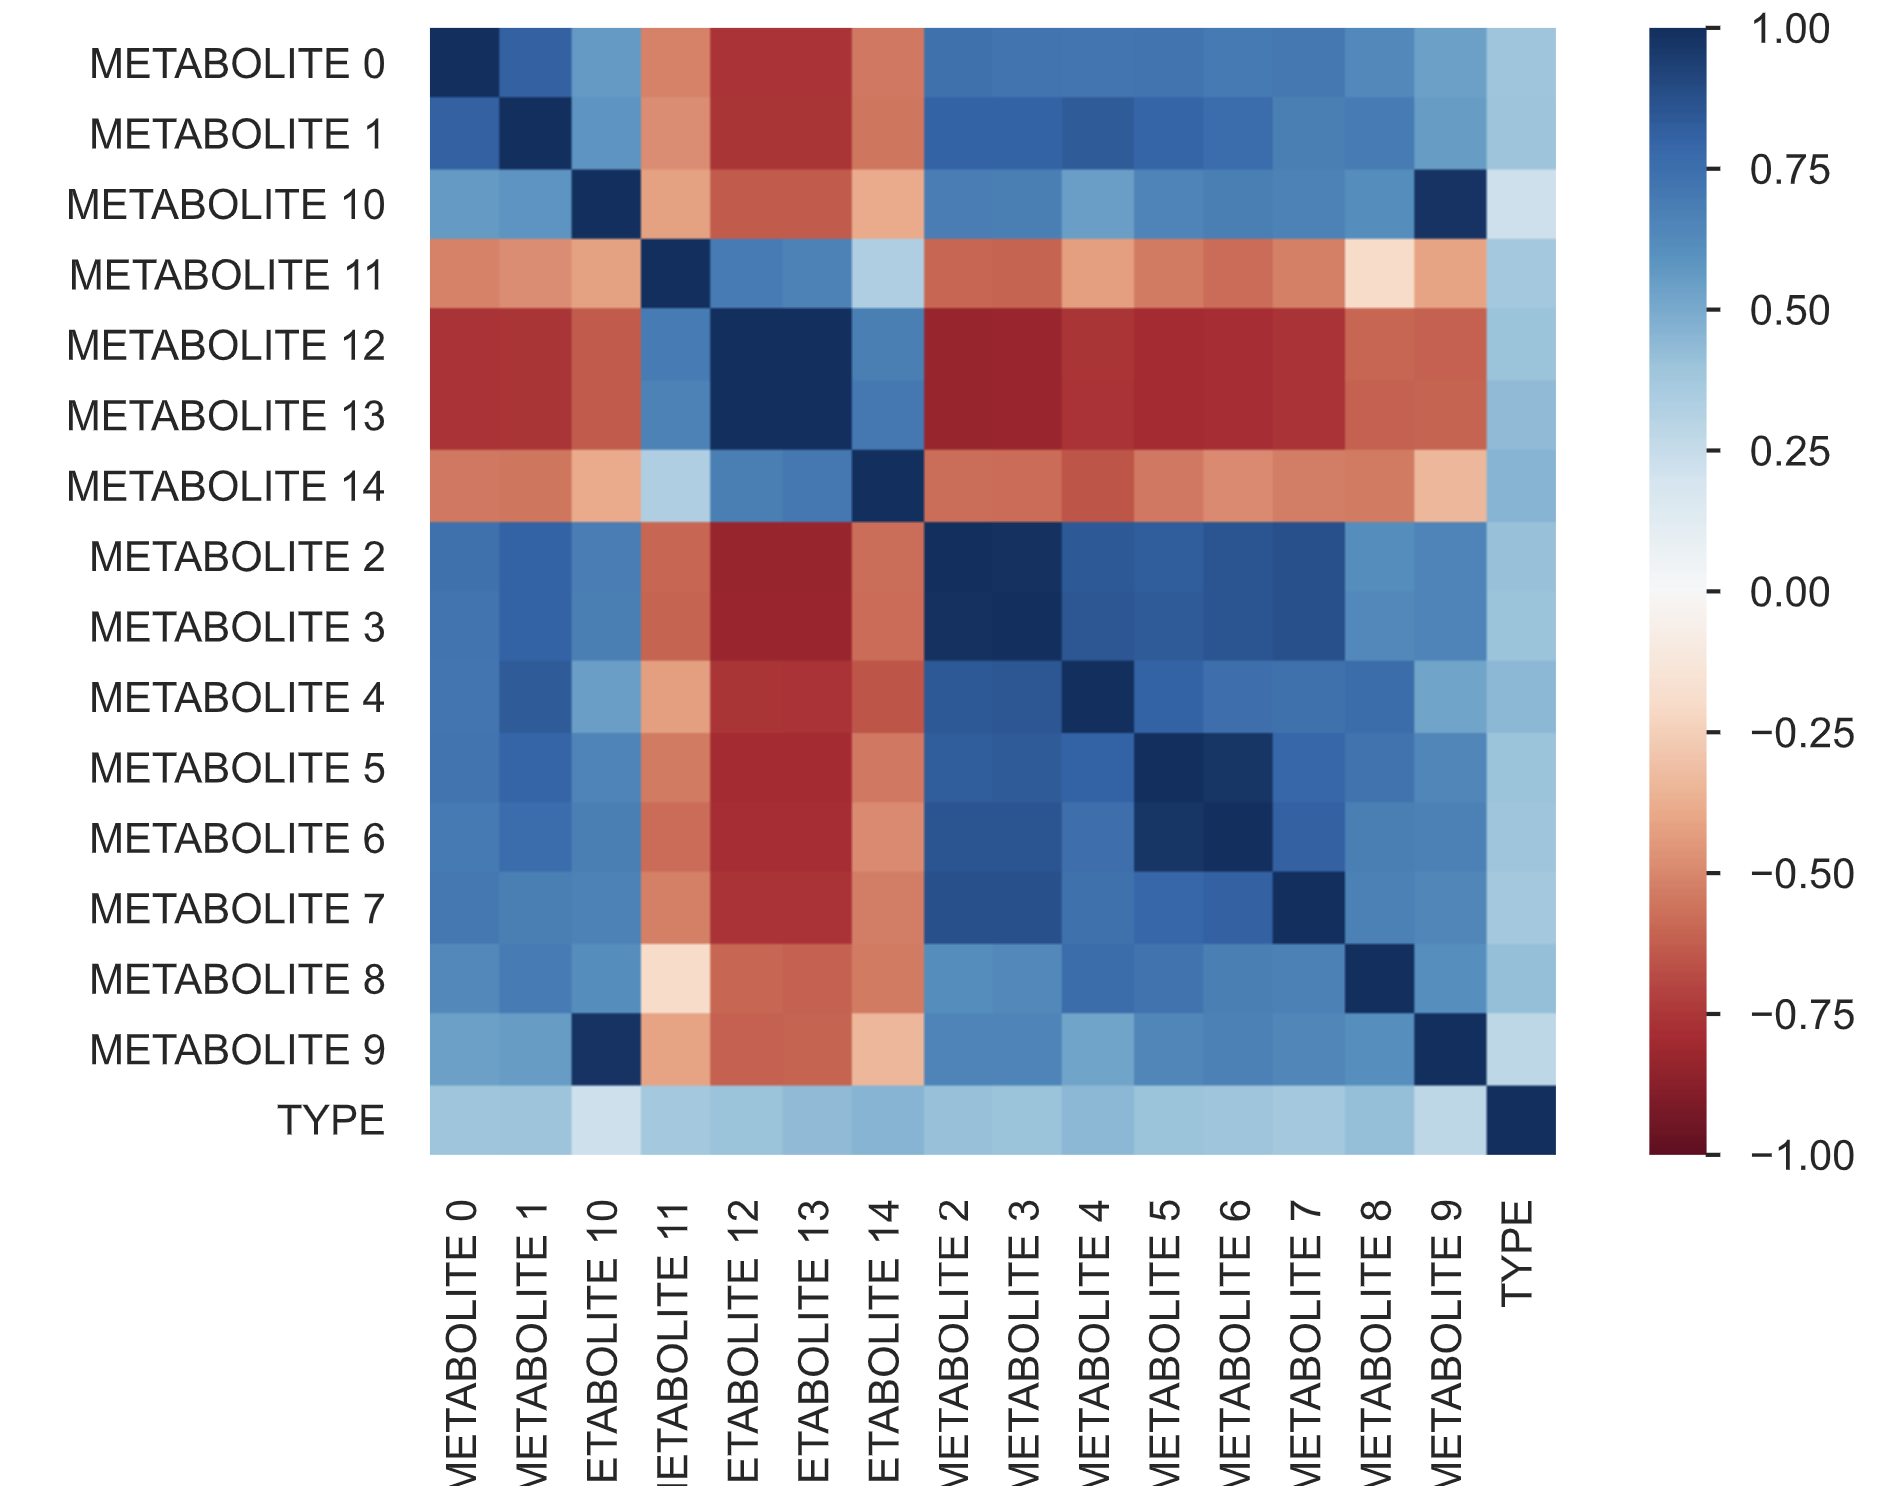

- Hay un desbalanceo en la variable objetivo que puede ser importante

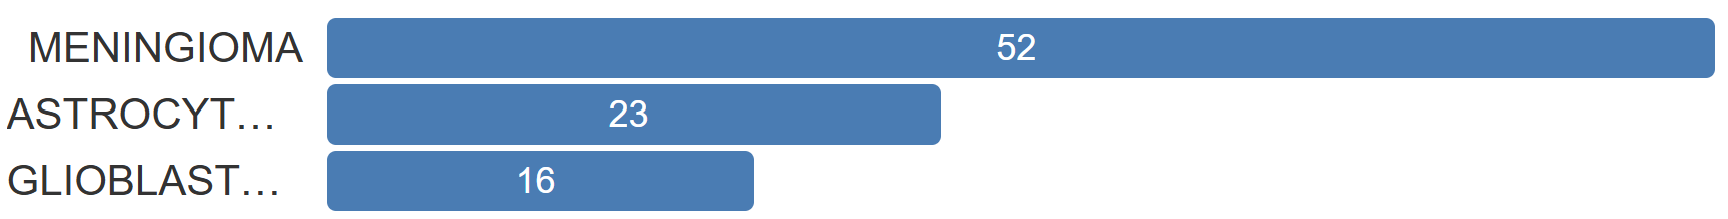

## 2. Create an auxiliary one hot encoded variable for each of the 3 types of brain tumors.

In [5]:
df['TYPE_ORG'] = df['TYPE']
df = pd.get_dummies(df, columns=['TYPE'])
df

,METABOLITE 0,METABOLITE 1,METABOLITE 2,METABOLITE 3,METABOLITE 4,METABOLITE 5,METABOLITE 6,METABOLITE 7,METABOLITE 8,METABOLITE 9,METABOLITE 10,METABOLITE 11,METABOLITE 12,METABOLITE 13,METABOLITE 14,TYPE_ORG,TYPE_ASTROCYTOMA,TYPE_GLIOBLASTOMA,TYPE_MENINGIOMA
0,0.322695,0.575024,0.742645,0.635958,0.544804,0.785336,0.885756,0.577938,0.123017,0.701689,0.731254,0.846980,3.551957,3.742832,1.719949,MENINGIOMA,False,False,True
1,0.457408,0.764700,0.444451,0.451300,0.388213,0.401597,0.382574,0.407632,0.715072,1.216084,1.204490,2.329079,3.179366,3.117351,1.252479,MENINGIOMA,False,False,True
2,1.452870,1.152910,0.647735,0.622494,0.648020,0.826787,0.797439,0.695269,0.850328,0.910488,0.914841,1.805095,2.156737,2.152553,1.081571,MENINGIOMA,False,False,True
3,0.157588,0.314415,0.251613,0.186498,0.100556,0.287618,0.334349,0.213802,0.305852,0.754096,0.627211,1.566407,4.274654,4.210731,1.128131,MENINGIOMA,False,False,True
4,0.368681,0.206993,0.211521,0.034699,0.164187,0.364590,0.340892,0.110287,0.260206,0.531801,0.496068,0.654805,4.070067,4.324002,1.350580,MENINGIOMA,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,1.146621,1.952639,1.240700,1.216044,0.873140,1.341280,1.344396,0.566293,0.714166,2.140718,2.027257,0.735564,0.975908,1.080736,0.984968,GLIOBLASTOMA,False,True,False
87,1.304585,1.048878,1.456252,1.391773,0.716365,1.224394,1.465654,1.349410,0.868388,2.699551,2.731945,0.795505,0.725981,0.700257,0.622597,GLIOBLASTOMA,False,True,False
88,1.648198,1.965646,0.913688,0.925384,1.040036,1.344963,1.313133,0.635587,0.974705,1.477950,1.421918,0.643054,1.233130,1.254060,1.052289,GLIOBLASTOMA,False,True,False
89,0.524946,0.711819,0.459294,0.450123,0.532891,0.464126,0.539442,0.431146,0.263541,1.087815,1.003663,0.888594,2.263318,2.392848,2.219673,GLIOBLASTOMA,False,True,False


## 3. Split your data using a holdout methodology considering odds of 70:30

In [6]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=23, stratify=df['TYPE_ORG'])

## 4. Perform robust scaling on each of the datasets generated in 3)

In [7]:
exclude_cols = ['TYPE_ORG'] + [col for col in train_df.columns if col.startswith('TYPE_')]
numeric_cols = [col for col in train_df.columns if col not in exclude_cols]

scaler = RobustScaler(quantile_range=(2.5, 97.5))

scaler.fit(train_df[numeric_cols])

train_df_scaled = train_df.copy()
test_df_scaled = test_df.copy()

train_df_scaled[numeric_cols] = scaler.transform(train_df[numeric_cols])
test_df_scaled[numeric_cols] = scaler.transform(test_df[numeric_cols])

In [8]:
X_train = train_df_scaled.drop(columns=['TYPE_ORG', 'TYPE_ASTROCYTOMA', 'TYPE_GLIOBLASTOMA', 'TYPE_MENINGIOMA'])
X_test = test_df_scaled.drop(columns=['TYPE_ORG', 'TYPE_ASTROCYTOMA', 'TYPE_GLIOBLASTOMA', 'TYPE_MENINGIOMA'])

y_train = train_df_scaled[['TYPE_ASTROCYTOMA', 'TYPE_GLIOBLASTOMA', 'TYPE_MENINGIOMA']]
y_test = test_df_scaled[['TYPE_ASTROCYTOMA', 'TYPE_GLIOBLASTOMA', 'TYPE_MENINGIOMA']]

# Block II. Model training and selection

## 1. Choose a proper evaluation metric suitable for the problem

Clases desbalanceadas: La distribución de las clases es la siguiente:
- MENINGIOMA: 52 muestras
- ASTROCYTOMA: 23 muestras
- GLIOBLASTOMA: 16 muestras

Dado que necesitamos una métrica que no esté sesgada por el desbalance de clases y que trate a todas las clases de manera equitativa, el F1-Score Macro Promediado es una opción adecuada. Esta métrica:

- Da igual importancia a todas las clases, independientemente del número de muestras.
- Combina precisión y recall, proporcionando una visión equilibrada del rendimiento del modelo.

## 2. Run some experiments: 

In [9]:
def create_model(learning_rate=0.001, architecture=[64, 32], input_dim=None):
    model = Sequential()

    for idx, units in enumerate(architecture):
        if idx == 0:
            model.add(Dense(units, input_dim=input_dim, activation='relu'))
        else:
            model.add(Dense(units, activation='relu'))

    model.add(Dense(3, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy')
    return model

In [10]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, batch_size=32, epochs=10):
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    return f1_macro

### 2.1 Learning rate

In [11]:
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
results_lr = []

input_dim = X_train.shape[1]

for lr in learning_rates:
    model = create_model(learning_rate=lr, input_dim=input_dim)
    f1_macro = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)
    results_lr.append({'learning_rate': lr, 'f1_macro': f1_macro})
    print(f"Learning rate: {lr}, F1 Macro Score: {f1_macro:.4f}")

1/1 [==============================] - 0s 71ms/step
Learning rate: 1e-05, F1 Macro Score: 0.3476
1/1 [==============================] - 0s 42ms/step
Learning rate: 0.0001, F1 Macro Score: 0.3984
1/1 [==============================] - 0s 31ms/step
Learning rate: 0.001, F1 Macro Score: 0.6227
1/1 [==============================] - 0s 56ms/step
Learning rate: 0.01, F1 Macro Score: 0.7383
1/1 [==============================] - 0s 31ms/step
Learning rate: 0.1, F1 Macro Score: 0.8755


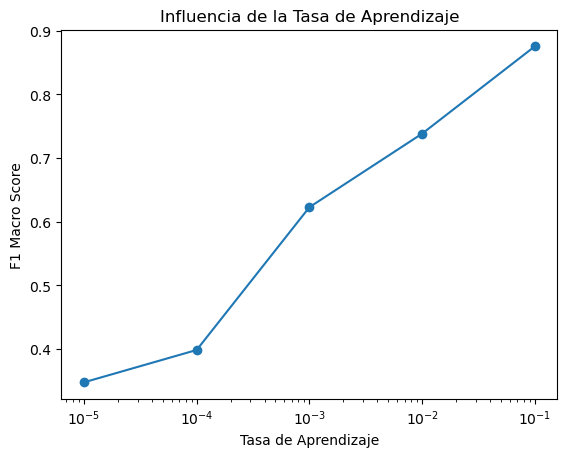

In [12]:
df_lr = pd.DataFrame(results_lr)
plt.figure()
plt.plot(df_lr['learning_rate'], df_lr['f1_macro'], marker='o')
plt.xscale('log')
plt.xlabel('Tasa de Aprendizaje')
plt.ylabel('F1 Macro Score')
plt.title('Influencia de la Tasa de Aprendizaje')
plt.show()

### 2.2 Batch size

In [13]:
batch_sizes = [8, 16, 32, 64, 128]
results_bs = []

for bs in batch_sizes:
    model = create_model(learning_rate=0.001, input_dim=input_dim)
    f1_macro = train_and_evaluate_model(model, X_train, y_train, X_test, y_test, batch_size=bs)
    results_bs.append({'batch_size': bs, 'f1_macro': f1_macro})
    print(f"Batch size: {bs}, F1 Macro Score: {f1_macro:.4f}")

1/1 [==============================] - 0s 31ms/step
Batch size: 8, F1 Macro Score: 0.8102
1/1 [==============================] - 0s 39ms/step
Batch size: 16, F1 Macro Score: 0.7138
1/1 [==============================] - 0s 31ms/step
Batch size: 32, F1 Macro Score: 0.4021
1/1 [==============================] - 0s 32ms/step
Batch size: 64, F1 Macro Score: 0.4444
1/1 [==============================] - 0s 31ms/step
Batch size: 128, F1 Macro Score: 0.3268


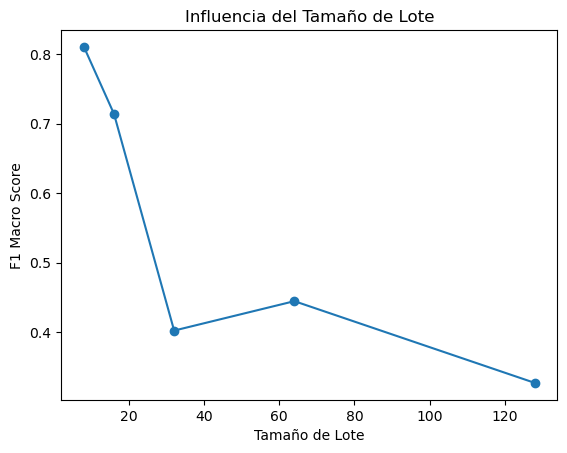

In [14]:
df_bs = pd.DataFrame(results_bs)
plt.figure()
plt.plot(df_bs['batch_size'], df_bs['f1_macro'], marker='o')
plt.xlabel('Tamaño de Lote')
plt.ylabel('F1 Macro Score')
plt.title('Influencia del Tamaño de Lote')
plt.show()

### 2.3 Architecture

In [15]:
architectures = [
    [32],
    [64],
    [128],
    [64, 32],
    [128, 64, 32],
    [256, 128, 64],
    [64, 64, 32],
    [128, 64, 16]
]
results_arch = []

for arch in architectures:
    model = create_model(learning_rate=0.001, architecture=arch, input_dim=input_dim)
    f1_macro = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)
    results_arch.append({'architecture': arch, 'f1_macro': f1_macro})
    arch_str = '-'.join(map(str, arch))
    print(f"Architecture: {arch_str}, F1 Macro Score: {f1_macro:.4f}")

1/1 [==============================] - 0s 31ms/step
Architecture: 32, F1 Macro Score: 0.4765
1/1 [==============================] - 0s 33ms/step
Architecture: 64, F1 Macro Score: 0.2949
1/1 [==============================] - 0s 37ms/step
Architecture: 128, F1 Macro Score: 0.7138
1/1 [==============================] - 0s 37ms/step
Architecture: 64-32, F1 Macro Score: 0.4107
1/1 [==============================] - 0s 31ms/step
Architecture: 128-64-32, F1 Macro Score: 0.5306
1/1 [==============================] - 0s 49ms/step
Architecture: 256-128-64, F1 Macro Score: 0.6782
1/1 [==============================] - 0s 45ms/step
Architecture: 64-64-32, F1 Macro Score: 0.6250
1/1 [==============================] - 0s 47ms/step
Architecture: 128-64-16, F1 Macro Score: 0.3922


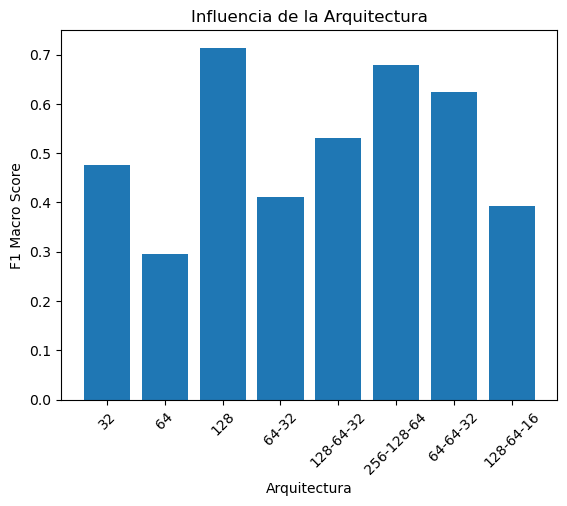

In [16]:
df_arch = pd.DataFrame(results_arch)
df_arch['architecture_str'] = df_arch['architecture'].apply(lambda x: '-'.join(map(str, x)))

plt.figure()
plt.bar(df_arch['architecture_str'], df_arch['f1_macro'])
plt.xlabel('Arquitectura')
plt.ylabel('F1 Macro Score')
plt.title('Influencia de la Arquitectura')
plt.xticks(rotation=45)
plt.show()

### 2.4 Number iterations 

In [17]:
epochs_list = [10, 50, 100, 200]
results_epochs = []

for epochs in epochs_list:
    model = create_model(learning_rate=0.001, input_dim=input_dim)
    f1_macro = train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=epochs)
    results_epochs.append({'epochs': epochs, 'f1_macro': f1_macro})
    print(f"Epochs: {epochs}, F1 Macro Score: {f1_macro:.4f}")

1/1 [==============================] - 0s 38ms/step
Epochs: 10, F1 Macro Score: 0.5098
1/1 [==============================] - 0s 31ms/step
Epochs: 50, F1 Macro Score: 0.8755
1/1 [==============================] - 0s 31ms/step
Epochs: 100, F1 Macro Score: 0.8755
1/1 [==============================] - 0s 47ms/step
Epochs: 200, F1 Macro Score: 0.9052


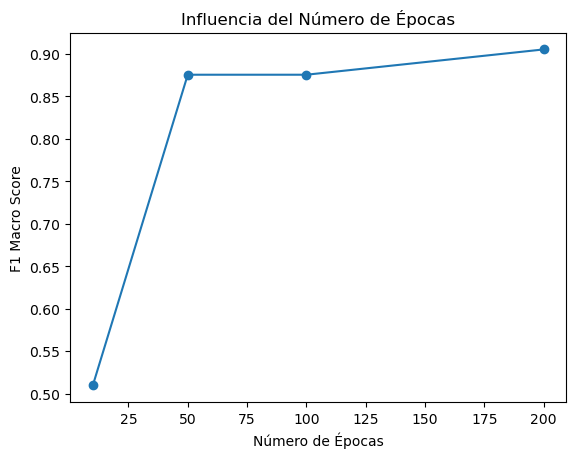

In [18]:
df_epochs = pd.DataFrame(results_epochs)
plt.figure()
plt.plot(df_epochs['epochs'], df_epochs['f1_macro'], marker='o')
plt.xlabel('Número de Épocas')
plt.ylabel('F1 Macro Score')
plt.title('Influencia del Número de Épocas')
plt.show()

## 3. Select the best hyperparams configuration

In [19]:
def train_and_evaluate_model(learning_rate, batch_size, architecture, epochs, input_dim, X_train, y_train, X_test, y_test):
    # Crear el modelo con los hiperparámetros especificados
    model = create_model(learning_rate=learning_rate, architecture=architecture, input_dim=input_dim)
    # Entrenar el modelo
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
    # Realizar predicciones en el conjunto de prueba
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)
    # Calcular el F1 Macro Score
    f1_macro = f1_score(y_true, y_pred, average='macro')
    return f1_macro

In [20]:
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
batch_sizes = [8, 16, 32, 64, 128]
architectures = [
    [32],
    [64],
    [128],
    [64, 32],
    [128, 64, 32],
    [256, 128, 64],
    [64, 64, 32],
    [128, 64, 16]
]
epochs_list = [10, 50, 100, 200]

param_grid = list(itertools.product(learning_rates, batch_sizes, architectures, epochs_list))

In [21]:
results = []

input_dim = X_train.shape[1]

# Iterar sobre todas las combinaciones de hiperparámetros
for lr, bs, arch, ep in param_grid:
    f1_macro = train_and_evaluate_model(
        learning_rate=lr,
        batch_size=bs,
        architecture=arch,
        epochs=ep,
        input_dim=input_dim,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )
    # Registrar el resultado
    results.append({
        'learning_rate': lr,
        'batch_size': bs,
        'architecture': arch,
        'epochs': ep,
        'f1_macro': f1_macro
    })
    print(f"Tasa de aprendizaje: {lr}, Tamaño de lote: {bs}, Arquitectura: {arch}, Epochs: {ep}, F1 Macro: {f1_macro:.4f}")

1/1 [==============================] - 0s 31ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 8, Arquitectura: [32], Epochs: 10, F1 Macro: 0.5945
1/1 [==============================] - 0s 44ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 8, Arquitectura: [32], Epochs: 50, F1 Macro: 0.2143
1/1 [==============================] - 0s 31ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 8, Arquitectura: [32], Epochs: 100, F1 Macro: 0.5396
1/1 [==============================] - 0s 31ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 8, Arquitectura: [32], Epochs: 200, F1 Macro: 0.4781
1/1 [==============================] - 0s 39ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 8, Arquitectura: [64], Epochs: 10, F1 Macro: 0.4158
1/1 [==============================] - 0s 31ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 8, Arquitectura: [64], Epochs: 50, F1 Macro: 0.1890
1/1 [==============================] - 0s 32ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 8, Arquitectur

1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 100, F1 Macro: 0.2424
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 200, F1 Macro: 0.5051
1/1 [==============================] - 0s 31ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 16, Arquitectura: [64, 64, 32], Epochs: 10, F1 Macro: 0.1600
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 16, Arquitectura: [64, 64, 32], Epochs: 50, F1 Macro: 0.2731
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 16, Arquitectura: [64, 64, 32], Epochs: 100, F1 Macro: 0.2505
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 16, Arquitectura: [64, 64, 32], Epochs: 200, F1 Macro: 0.5940
1/1 [==============================] - 0s 47ms/ste

1/1 [==============================] - 0s 50ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 64, Arquitectura: [128], Epochs: 200, F1 Macro: 0.6203
1/1 [==============================] - 0s 65ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 10, F1 Macro: 0.1290
1/1 [==============================] - 0s 57ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 50, F1 Macro: 0.2286
1/1 [==============================] - 0s 70ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 100, F1 Macro: 0.1333
1/1 [==============================] - 0s 63ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 200, F1 Macro: 0.3214
1/1 [==============================] - 0s 64ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 64, Arquitectura: [128, 64, 32], Epochs: 10, F1 Macro: 0.2424
1/1 [==============================] - 0s 63ms/step
Tasa de aprendizaje: 1e-0

1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 8, Arquitectura: [32], Epochs: 10, F1 Macro: 0.4788
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 8, Arquitectura: [32], Epochs: 50, F1 Macro: 0.5880
1/1 [==============================] - 0s 59ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 8, Arquitectura: [32], Epochs: 100, F1 Macro: 0.2999
1/1 [==============================] - 0s 50ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 8, Arquitectura: [32], Epochs: 200, F1 Macro: 0.7138
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 8, Arquitectura: [64], Epochs: 10, F1 Macro: 0.4989
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 8, Arquitectura: [64], Epochs: 50, F1 Macro: 0.5022
1/1 [==============================] - 0s 53ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 8, Arqu

1/1 [==============================] - 0s 59ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 50, F1 Macro: 0.7138
1/1 [==============================] - 0s 256ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 100, F1 Macro: 0.8755
1/1 [==============================] - 0s 123ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 200, F1 Macro: 0.9052
1/1 [==============================] - 0s 94ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 16, Arquitectura: [64, 64, 32], Epochs: 10, F1 Macro: 0.2481
1/1 [==============================] - 0s 129ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 16, Arquitectura: [64, 64, 32], Epochs: 50, F1 Macro: 0.2424
1/1 [==============================] - 0s 97ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 16, Arquitectura: [64, 64, 32], Epochs: 100, F1 Macro: 0.4680
1/1 [==============================] - 0

1/1 [==============================] - 0s 206ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 64, Arquitectura: [128], Epochs: 100, F1 Macro: 0.4706
1/1 [==============================] - 0s 94ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 64, Arquitectura: [128], Epochs: 200, F1 Macro: 0.5051
1/1 [==============================] - 0s 159ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 10, F1 Macro: 0.1444
1/1 [==============================] - 0s 114ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 50, F1 Macro: 0.4287
1/1 [==============================] - 0s 63ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 100, F1 Macro: 0.4714
1/1 [==============================] - 0s 61ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 200, F1 Macro: 0.4333
1/1 [==============================] - 0s 50ms/step
Tasa de aprendizaje: 0.

1/1 [==============================] - 0s 53ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 128, Arquitectura: [128, 64, 16], Epochs: 100, F1 Macro: 0.3268
1/1 [==============================] - 0s 81ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 128, Arquitectura: [128, 64, 16], Epochs: 200, F1 Macro: 0.7138
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 8, Arquitectura: [32], Epochs: 10, F1 Macro: 0.7864
1/1 [==============================] - 0s 63ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 8, Arquitectura: [32], Epochs: 50, F1 Macro: 0.7864
1/1 [==============================] - 0s 46ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 8, Arquitectura: [32], Epochs: 100, F1 Macro: 0.8755
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 8, Arquitectura: [32], Epochs: 200, F1 Macro: 0.9052
1/1 [==============================] - 0s 52ms/step
Tasa de aprendizaje: 0.001, Tama

1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 10, F1 Macro: 0.8399
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 50, F1 Macro: 0.8374
1/1 [==============================] - 0s 69ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 100, F1 Macro: 0.8374
1/1 [==============================] - 0s 60ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 200, F1 Macro: 0.8374
1/1 [==============================] - 0s 63ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 16, Arquitectura: [64, 64, 32], Epochs: 10, F1 Macro: 0.5294
1/1 [==============================] - 0s 53ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 16, Arquitectura: [64, 64, 32], Epochs: 50, F1 Macro: 0.8102
1/1 [==============================] - 0s 84ms/s

1/1 [==============================] - 0s 62ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 64, Arquitectura: [128], Epochs: 50, F1 Macro: 0.7138
1/1 [==============================] - 0s 52ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 64, Arquitectura: [128], Epochs: 100, F1 Macro: 0.7864
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 64, Arquitectura: [128], Epochs: 200, F1 Macro: 0.8755
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 10, F1 Macro: 0.5011
1/1 [==============================] - 0s 63ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 50, F1 Macro: 0.7138
1/1 [==============================] - 0s 63ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 100, F1 Macro: 0.8755
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.001, Tamaño d

1/1 [==============================] - 0s 63ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 128, Arquitectura: [128, 64, 16], Epochs: 100, F1 Macro: 0.8755
1/1 [==============================] - 0s 48ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 128, Arquitectura: [128, 64, 16], Epochs: 200, F1 Macro: 0.8374
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 8, Arquitectura: [32], Epochs: 10, F1 Macro: 0.8474
1/1 [==============================] - 0s 63ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 8, Arquitectura: [32], Epochs: 50, F1 Macro: 0.8374
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 8, Arquitectura: [32], Epochs: 100, F1 Macro: 0.8374
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 8, Arquitectura: [32], Epochs: 200, F1 Macro: 0.8755
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.01, Tamaño de l

1/1 [==============================] - 0s 76ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 10, F1 Macro: 0.8755
1/1 [==============================] - 0s 84ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 50, F1 Macro: 0.8374
1/1 [==============================] - 0s 91ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 100, F1 Macro: 0.8374
1/1 [==============================] - 0s 93ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 200, F1 Macro: 0.8374
1/1 [==============================] - 0s 78ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 16, Arquitectura: [64, 64, 32], Epochs: 10, F1 Macro: 0.8474
1/1 [==============================] - 0s 79ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 16, Arquitectura: [64, 64, 32], Epochs: 50, F1 Macro: 0.8102
1/1 [==============================] - 0s 78ms/step
Ta

Tasa de aprendizaje: 0.01, Tamaño de lote: 64, Arquitectura: [128], Epochs: 50, F1 Macro: 0.8755
1/1 [==============================] - 0s 31ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 64, Arquitectura: [128], Epochs: 100, F1 Macro: 0.8374
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 64, Arquitectura: [128], Epochs: 200, F1 Macro: 0.8374
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 10, F1 Macro: 0.7383
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 50, F1 Macro: 0.8755
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 100, F1 Macro: 0.8374
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 200, F1 Macro: 

1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 128, Arquitectura: [128, 64, 16], Epochs: 100, F1 Macro: 0.8755
1/1 [==============================] - 0s 58ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 128, Arquitectura: [128, 64, 16], Epochs: 200, F1 Macro: 0.8755
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 8, Arquitectura: [32], Epochs: 10, F1 Macro: 0.8042
1/1 [==============================] - 0s 62ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 8, Arquitectura: [32], Epochs: 50, F1 Macro: 0.8374
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 8, Arquitectura: [32], Epochs: 100, F1 Macro: 0.8374
1/1 [==============================] - 0s 46ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 8, Arquitectura: [32], Epochs: 200, F1 Macro: 0.7955
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 8,

1/1 [==============================] - 0s 48ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 10, F1 Macro: 0.8261
1/1 [==============================] - 0s 60ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 50, F1 Macro: 0.4437
1/1 [==============================] - 0s 60ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 100, F1 Macro: 0.4577
1/1 [==============================] - 0s 63ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 200, F1 Macro: 0.6899
1/1 [==============================] - 0s 62ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 16, Arquitectura: [64, 64, 32], Epochs: 10, F1 Macro: 0.6875
1/1 [==============================] - 0s 63ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 16, Arquitectura: [64, 64, 32], Epochs: 50, F1 Macro: 0.6663
1/1 [==============================] - 0s 79ms/step
Tasa de 

1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 64, Arquitectura: [128], Epochs: 100, F1 Macro: 0.8374
1/1 [==============================] - 0s 48ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 64, Arquitectura: [128], Epochs: 200, F1 Macro: 0.8755
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 10, F1 Macro: 0.8233
1/1 [==============================] - 0s 56ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 50, F1 Macro: 0.8755
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 100, F1 Macro: 0.8374
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 200, F1 Macro: 0.8755
1/1 [==============================] - 0s 56ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 64

1/1 [==============================] - 0s 84ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 128, Arquitectura: [128, 64, 16], Epochs: 200, F1 Macro: 0.7546


In [22]:
results_df = pd.DataFrame(results)

# Encontrar la mejor configuración
best_result = results_df.loc[results_df['f1_macro'].idxmax()]
print("\nMejor Configuración de Hiperparámetros:")
print(f"Tasa de Aprendizaje: {best_result['learning_rate']}")
print(f"Tamaño de Lote: {best_result['batch_size']}")
print(f"Arquitectura: {best_result['architecture']}")
print(f"Épocas: {best_result['epochs']}")
print(f"Mejor F1 Macro Score: {best_result['f1_macro']:.4f}")


Mejor Configuración de Hiperparámetros:
Tasa de Aprendizaje: 0.0001
Tamaño de Lote: 8
Arquitectura: [256, 128, 64]
Épocas: 100
Mejor F1 Macro Score: 0.9052


### 3.1 Brief discussion of the experimental procedure, along with the results obtained

...

### 3.2 Estimate model performance with the validation set

In [23]:
X_full = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
y_full = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

y_full_labels = np.argmax(y_full.values, axis=1)

In [24]:
X_full_values = X_full.values
y_full_values = y_full.values  # Etiquetas one-hot encoding
y_full_labels = np.argmax(y_full_values, axis=1)  # Etiquetas categóricas

# Definir las clases
class_names = ['ASTROCYTOMA', 'GLIOBLASTOMA', 'MENINGIOMA']

# Configurar la validación cruzada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Almacenar las métricas
precision_scores = []
recall_scores = []
f1_scores = []
auc_scores = []

for train_index, val_index in skf.split(X_full_values, y_full_labels):
    X_train_cv, X_val_cv = X_full_values[train_index], X_full_values[val_index]
    y_train_cv, y_val_cv = y_full_values[train_index], y_full_values[val_index]
    y_val_labels = y_full_labels[val_index]
    
    # Crear y compilar el modelo
    model_cv = create_model(
        learning_rate=best_result['learning_rate'],
        architecture=best_result['architecture'],
        input_dim=X_full_values.shape[1]
    )
    
    # Entrenar el modelo
    model_cv.fit(
        X_train_cv,
        y_train_cv,
        batch_size=best_result['batch_size'],
        epochs=int(best_result['epochs']),
        verbose=0
    )
    
    # Predecir las probabilidades
    y_pred_prob = model_cv.predict(X_val_cv)
    y_pred_labels = np.argmax(y_pred_prob, axis=1)
    
    # Calcular las métricas
    precision, recall, f1, _ = precision_recall_fscore_support(y_val_labels, y_pred_labels, average=None, labels=[0,1,2])
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    
    # Calcular AUC para cada clase
    y_val_binarized = y_val_cv  # Ya en formato one-hot
    auc = roc_auc_score(y_val_binarized, y_pred_prob, average=None, multi_class='ovr')
    auc_scores.append(auc)

# Promediar las métricas a través de las iteraciones
mean_precision = np.mean(precision_scores, axis=0)
mean_recall = np.mean(recall_scores, axis=0)
mean_f1 = np.mean(f1_scores, axis=0)
mean_auc = np.mean(auc_scores, axis=0)

# Mostrar las métricas para cada clase
for idx, class_name in enumerate(class_names):
    print(f"\nMétricas para {class_name}:")
    print(f"Precisión: {mean_precision[idx]:.4f}")
    print(f"Recall: {mean_recall[idx]:.4f}")
    print(f"F1-Score: {mean_f1[idx]:.4f}")
    print(f"AUC: {mean_auc[idx]:.4f}")

1/1 [==============================] - 0s 69ms/step

Métricas para ASTROCYTOMA:
Precisión: 0.6933
Recall: 0.6700
F1-Score: 0.6605
AUC: 0.9057

Métricas para GLIOBLASTOMA:
Precisión: 0.7533
Recall: 0.6833
F1-Score: 0.6948
AUC: 0.8922

Métricas para MENINGIOMA:
Precisión: 0.8365
Recall: 0.8673
F1-Score: 0.8431
AUC: 0.9023


### 3.3 Retrain your model with the whole training data, considering the best hyperparams set

In [29]:
best_model = create_model(
    learning_rate=best_result['learning_rate'],
    architecture=best_result['architecture'],
    input_dim=input_dim
)

history = best_model.fit(
            X_train,
            y_train,
            batch_size=best_result['batch_size'],
            epochs=int(best_result['epochs']),
            verbose=0
        )

# Evaluar el mejor modelo
y_pred_prob = best_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f"\nF1 Macro Score del Mejor Modelo Reentrenado: {f1_macro:.4f}")

# Reporte de clasificación detallado

label_mapping = {'ASTROCYTOMA': 0, 'GLIOBLASTOMA': 1, 'MENINGIOMA': 2}
print("\nReporte de Clasificación para el Mejor Modelo:")
print(classification_report(y_true, y_pred, target_names=label_mapping.keys()))

1/1 [==============================] - 0s 45ms/step

F1 Macro Score del Mejor Modelo Reentrenado: 0.8755

Reporte de Clasificación para el Mejor Modelo:
              precision    recall  f1-score   support

 ASTROCYTOMA       0.75      0.86      0.80         7
GLIOBLASTOMA       1.00      0.80      0.89         5
  MENINGIOMA       0.94      0.94      0.94        16

    accuracy                           0.89        28
   macro avg       0.90      0.86      0.88        28
weighted avg       0.90      0.89      0.89        28



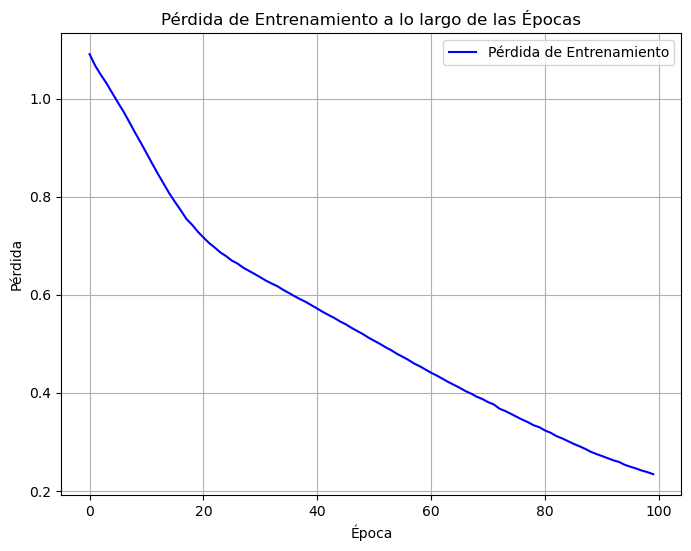

In [30]:
loss = history.history['loss']

# Crear la figura
plt.figure(figsize=(8,6))
plt.plot(loss, label='Pérdida de Entrenamiento', color='blue')
plt.title('Pérdida de Entrenamiento a lo largo de las Épocas')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
best_model.save('mejor_modelo.h5')

# Block III. Clinical decision support system deployment

In [ ]:
# app.py

import streamlit as st
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import RobustScaler
import joblib  # Para cargar el escalador guardado

# Título de la aplicación
st.title("Predicción de Diagnóstico de Tumores Cerebrales")

st.write("""
Esta aplicación permite cargar datos de concentraciones de metabolitos para predecir el tipo de tumor cerebral.
""")

# Cargar el modelo guardado
@st.cache_resource
def load_saved_model():
    model = load_model('mejor_modelo.h5')
    return model

# Cargar el escalador guardado
@st.cache_resource
def load_scaler():
    scaler = joblib.load('robust_scaler.joblib')
    return scaler

model = load_saved_model()
scaler = load_scaler()

# Cargar el archivo CSV de entrada
uploaded_file = st.file_uploader("Carga un archivo CSV con las concentraciones de metabolitos", type=["csv"])

if uploaded_file is not None:
    # Leer el archivo CSV
    input_data = pd.read_csv(uploaded_file)
    
    st.write("Datos cargados:")
    st.write(input_data.head())

    # Verificar si las columnas necesarias están presentes
    required_columns = [f"Metabolite {i}" for i in range(15)]  # Lista de nombres de columnas de metabolitos esperados
    if all(col in input_data.columns for col in required_columns):
        # Preprocesar los datos
        X_input = input_data[required_columns]
        X_scaled = scaler.transform(X_input)
        
        # Realizar las predicciones
        predictions = model.predict(X_scaled)
        
        # Obtener las probabilidades y el diagnóstico recomendado
        diagnosis_classes = ['ASTROCYTOMA', 'GLIOBLASTOMA', 'MENINGIOMA']
        predicted_classes = np.argmax(predictions, axis=1)
        predicted_labels = [diagnosis_classes[i] for i in predicted_classes]
        
        # Crear un DataFrame con los resultados
        results = input_data.copy()
        for idx, diagnosis in enumerate(diagnosis_classes):
            results[f'Probabilidad_{diagnosis}'] = predictions[:, idx]
        results['Diagnóstico_Predicho'] = predicted_labels
        
        st.write("Resultados de la predicción:")
        st.write(results.head())
        
        # Botón para descargar los resultados
        @st.cache_data
        def convert_df(df):
            return df.to_csv(index=False).encode('utf-8')
        
        csv = convert_df(results)
        
        st.download_button(
            label="Descargar resultados como CSV",
            data=csv,
            file_name='resultados_prediccion.csv',
            mime='text/csv',
        )
    else:
        st.error("El archivo CSV no contiene las columnas necesarias. Por favor, verifica el formato del archivo.")
